In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
print("Files added")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Files added


# Imports

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, concatenate, Input, Lambda, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import cv2
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Model

In [3]:
def build_unet_model(input_size=(256, 256, 6)):
    inputs = Input(input_size)
    
    # Split the input into two separate RGB images
    input_image1 = inputs[..., :3]
    input_image2 = inputs[..., 3:]
    
    # Encoder for image 1
    c1_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_image1)
    c1_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1_1)
    c1_1 = Dropout(0.3)(c1_1)  # Dropout after convolutional blocks
    p1_1 = MaxPooling2D((2, 2))(c1_1)

    c2_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1_1)
    c2_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2_1)
    c2_1 = Dropout(0.3)(c2_1)  # Dropout after convolutional blocks
    p2_1 = MaxPooling2D((2, 2))(c2_1)

    c3_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2_1)
    c3_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3_1)
    c3_1 = Dropout(0.3)(c3_1)  # Dropout after convolutional blocks
    p3_1 = MaxPooling2D((2, 2))(c3_1)

    # Encoder for image 2 (same as image 1)
    c1_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_image2)
    c1_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1_2)
    c1_2 = Dropout(0.3)(c1_2)  # Dropout after convolutional blocks
    p1_2 = MaxPooling2D((2, 2))(c1_2)

    c2_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1_2)
    c2_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2_2)
    c2_2 = Dropout(0.3)(c2_2)  # Dropout after convolutional blocks
    p2_2 = MaxPooling2D((2, 2))(c2_2)

    c3_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2_2)
    c3_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3_2)
    c3_2 = Dropout(0.3)(c3_2)  # Dropout after convolutional blocks
    p3_2 = MaxPooling2D((2, 2))(c3_2)

    # Bottleneck (concatenate the features from both images)
    c4_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3_1)
    c4_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4_1)
    c4_1 = Dropout(0.4)(c4_1)  # Dropout after convolutional blocks

    c4_2 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3_2)
    c4_2 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4_2)
    c4_2 = Dropout(0.4)(c4_2)  # Dropout after convolutional blocks

    # Combine the features of both images at the bottleneck
    c4 = concatenate([c4_1, c4_2])

    # Decoder
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3_1, c3_2])  # Skip connection from both images encoders
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    c5 = Dropout(0.3)(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2_1, c2_2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    c6 = Dropout(0.3)(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1_1, c1_2])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.3)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    c7 = Dropout(0.3)(c7)

    # Final output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    model = Model(inputs, outputs)
    
    return model


In [4]:
def build_unet_with_resnet(input_shape=(256, 256, 6)):
    # Split the input into two separate images (image1 and image2)
    inputs = Input(input_shape)
    input_image1 = inputs[..., :3]  # First 3 channels
    input_image2 = inputs[..., 3:]  # Last 3 channels

    # Pretrained ResNet50 as the backbone
    base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

    # Extract encoder layers
    encoder_layers1 = [
        base_model.get_layer("conv1_relu").output, 
        base_model.get_layer("conv2_block3_out").output, 
        base_model.get_layer("conv3_block4_out").output, 
        base_model.get_layer("conv4_block6_out").output, 
        base_model.get_layer("conv5_block3_out").output  
    ]

    # Create the encoder model for image1
    encoder1 = Model(inputs=base_model.input, outputs=encoder_layers1)
    encoder1.trainable = False  # Freeze pretrained layers initially
    
    # Extract features for image1
    encoder_outputs1 = encoder1(input_image1)

    # Extract features for image2 using the same encoder
    encoder_outputs2 = encoder1(input_image2)

    # Combine encoder outputs
    combined_features = [
        Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]), name=f"abs_diff_{i}")([feat1, feat2])
        for i, (feat1, feat2) in enumerate(zip(encoder_outputs1, encoder_outputs2))
    ]
    
    # Decoder with skip connections
    c1, c2, c3, c4, c5 = combined_features

    # Decoder 1
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.3)(c6)  # Add Dropout here
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = Dropout(0.3)(c6)  # Add Dropout here

    # Decoder 2
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.3)(c7)  # Add Dropout here
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = Dropout(0.3)(c7)  # Add Dropout here

    # Decoder 3
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.3)(c8)  # Add Dropout here
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = Dropout(0.3)(c8)  # Add Dropout here

    # Decoder 4
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.3)(c9)  # Add Dropout here
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = Dropout(0.3)(c9)  # Add Dropout here

    # Final output
    u10 = UpSampling2D((2, 2))(c9)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u10)

    model = Model(inputs, outputs)
    return model

In [5]:
input_shape = (256, 256, 6)

In [6]:
model_unet = build_unet_model(input_shape)
model_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', metrics=['accuracy'])

model_unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 6)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 256, 256, 64)   │          1,792 │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256, 256, 64)   │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 128, 128, 64)   │              0 │ dropout_3[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128, 128, 128)  │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 13,681,153 (52.19 MB)

 Trainable params: 13,681,153 (52.19 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model_unet_with_resnet = build_unet_with_resnet(input_shape)
model_unet_with_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', metrics=['accuracy'])

model_unet_with_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 6)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 256, 256, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 256, 256, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ [(None, 128, 128, 64), │     23,587,712 │ get_item_2[0][0],      │
│                           │ (None, 64, 64, 256),   │                │ get_item_3[0][0]       │
│                           │ (None, 32, 32, 512),   │                │                        │
│                           │ (None, 16, 16, 1024),  │                │                        │
│                           │ (None, 8, 8, 2048)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ abs_diff_4 (Lambda)       │ (None, 8, 8, 2048)     │              0 │ functional_1[0][4],    │
│                           │                        │                │ functional_1[1][4]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 2048)   │              0 │ abs_diff_4[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ abs_diff_3 (Lambda)       │ (None, 16, 16, 1024)   │              0 │ functional_1[0][3],    │
│                           │                        │                │ functional_1[1][3]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 16, 16, 3072)   │              0 │ up_sampling2d[0][0],   │
│ (Concatenate)             │                        │                │ abs_diff_3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 16, 16, 512)    │     14,156,288 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 16, 16, 512)    │              0 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 16, 16, 512)    │              0 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 32, 32, 512)    │              0 │ dropout_15[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ abs_diff_2 (Lambda)       │ (None, 32, 32, 512)    │              0 │ functional_1[0][2],    │
│                           │                        │                │ functional_1[1][2]     │
├──────────────────────

 Total params: 43,938,625 (167.61 MB)

 Trainable params: 20,350,913 (77.63 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Loading data

In [8]:
# Paths to LEVIR-CD+ dataset
image1_train_dir = "/kaggle/input/levir-cd-change-detection/LEVIR-CD+/train/A"
image2_train_dir = "/kaggle/input/levir-cd-change-detection/LEVIR-CD+/train/B"
mask_train_dir = "/kaggle/input/levir-cd-change-detection/LEVIR-CD+/train/label"

image1_test_dir = "/kaggle/input/levir-cd-change-detection/LEVIR-CD+/test/A"
image2_test_dir = "/kaggle/input/levir-cd-change-detection/LEVIR-CD+/test/B"
mask_test_dir = "/kaggle/input/levir-cd-change-detection/LEVIR-CD+/test/label"

input_shape = (256, 256)  # Resize dimensions

def load_images(image1_dir, image2_dir, mask_dir):
    image1_files = sorted(os.listdir(image1_dir))
    image2_files = sorted(os.listdir(image2_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    X = []
    y = []
    
    for img1, img2, mask in zip(image1_files, image2_files, mask_files):
        
        img1_path = os.path.join(image1_dir, img1)
        img2_path = os.path.join(image2_dir, img2)
        mask_path = os.path.join(mask_dir, mask)
        
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Resize images and mask
        img1 = cv2.resize(img1, input_shape)
        img2 = cv2.resize(img2, input_shape)
        mask = cv2.resize(mask, input_shape)
        
        # Normalize images and mask
        img1 = img1 / 255.0
        img2 = img2 / 255.0
        mask = mask / 255.0
        
        # Stack images along the channel axis
        stacked_image = np.concatenate([img1, img2], axis=-1)  # Shape: (256, 256, 6)
        
        X.append(stacked_image)
        y.append(mask)
    
    return np.array(X), np.array(y)

# Load the dataset
X, y = load_images(image1_train_dir, image2_train_dir, mask_train_dir)
X_test, y_test = load_images(image1_test_dir, image2_test_dir, mask_test_dir)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Training set size: (509, 256, 256, 6)
Validation set size: (128, 256, 256, 6)
Test set size: (348, 256, 256, 6)


# Model training

In [9]:
callbacks_unet = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_change_detection_unet_model.keras", monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]

In [10]:
callbacks_unet_with_resnet = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_change_detection_unet_resnet_model.keras", monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]

In [11]:
history_unet = model_unet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=25,
    verbose=1,
    callbacks=callbacks_unet
)

Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9185 - loss: 0.4046
Epoch 1: val_loss improved from inf to 0.22862, saving model to best_change_detection_unet_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 688ms/step - accuracy: 0.9189 - loss: 0.4029 - val_accuracy: 0.9516 - val_loss: 0.2286 - learning_rate: 1.0000e-04
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9515 - loss: 0.2078
Epoch 2: val_loss improved from 0.22862 to 0.16286, saving model to best_change_detection_unet_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 274ms/step - accuracy: 0.9515 - loss: 0.2077 - val_accuracy: 0.9516 - val_loss: 0.1629 - learning_rate: 1.0000e-04
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9533 - loss: 0.1483
Epoch 3: val_loss improved from 0.16286 to 0.12900, saving model to best_change_detection_unet_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 274ms/step - accuracy: 0.9533 - loss: 0.1483 - val_accuracy: 0.9516 - val_loss: 0.1290 - learning_rate

In [12]:
history_unet_with_resnet = model_unet_with_resnet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=25,
    verbose=1,
    callbacks=callbacks_unet_with_resnet
)

Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9417 - loss: 0.3697
Epoch 1: val_loss improved from inf to 0.25626, saving model to best_change_detection_unet_resnet_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 467ms/step - accuracy: 0.9418 - loss: 0.3688 - val_accuracy: 0.9516 - val_loss: 0.2563 - learning_rate: 1.0000e-04
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9497 - loss: 0.2355
Epoch 2: val_loss improved from 0.25626 to 0.24131, saving model to best_change_detection_unet_resnet_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.9497 - loss: 0.2352 - val_accuracy: 0.9516 - val_loss: 0.2413 - learning_rate: 1.0000e-04
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9519 - loss: 0.1914
Epoch 3: val_loss improved from 0.24131 to 0.18519, saving model to best_change_detection_unet_resnet_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.9518 - loss: 0.1915 - val_accuracy: 0.9516 - val_loss: 0.185

# Visualization

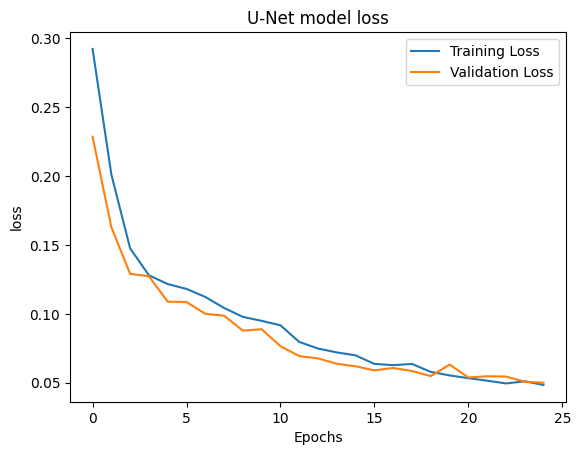

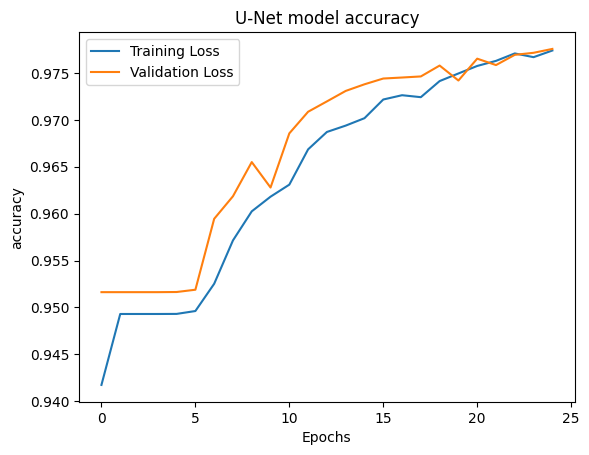

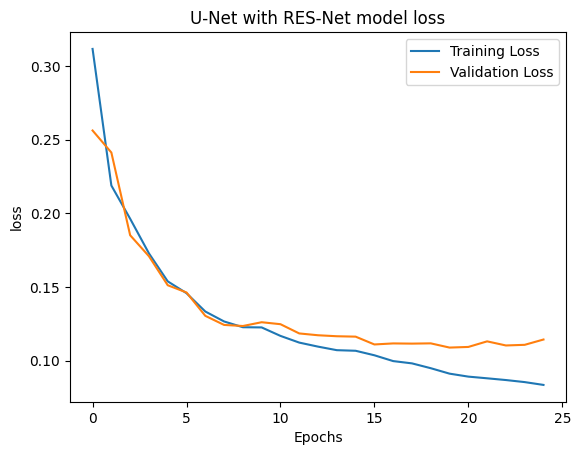

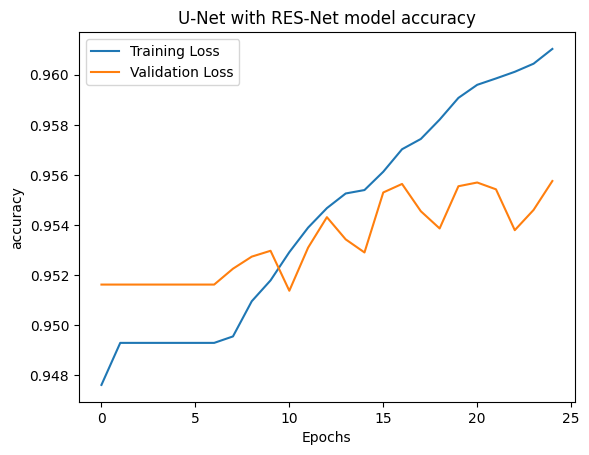

In [13]:
models = ['U-Net model', 'U-Net with RES-Net model']
history = [history_unet, history_unet_with_resnet]
for i in range(2):
    for metric in ['loss', 'accuracy']:
        plt.plot(history[i].history[metric], label='Training Loss')
        plt.plot(history[i].history['val_' + metric], label='Validation Loss')
        plt.title(models[i] + ' ' + metric)
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.show()

In [14]:
# Evaluate the model
test_loss, test_accuracy = model_unet_with_resnet.evaluate(X_test, y_test, batch_size=8, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict on test set
predictions_unet_with_resnet = model_unet_with_resnet.predict(X_test, batch_size=8, verbose=1)
#predicted_masks = (predictions > 0.5).astype(int)

44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.9589 - loss: 0.1631
Test Loss: 0.1688433736562729, Test Accuracy: 0.9569041132926941
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step


In [15]:
# Evaluate the model
test_loss, test_accuracy = model_unet.evaluate(X_test, y_test, batch_size=8, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict on test set
predictions_unet = model_unet.predict(X_test, batch_size=8, verbose=1)
#predicted_masks = (predictions > 0.5).astype(int)

44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.9717 - loss: 0.0672
Test Loss: 0.07439176738262177, Test Accuracy: 0.9692749381065369
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step


-----------------------------U-Net model----------------------------------------


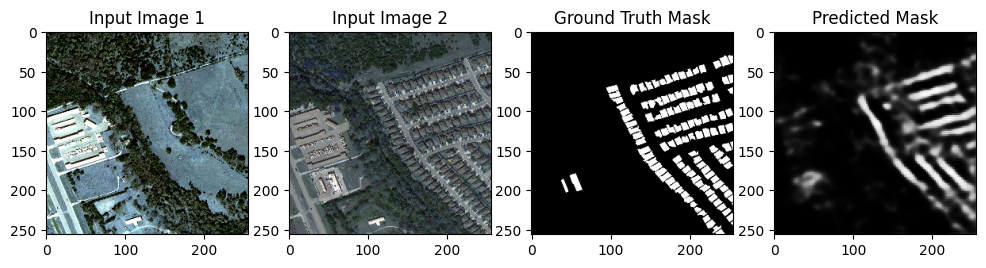

Predictions Min: 4.697977473711035e-08, Max: 0.853434145450592


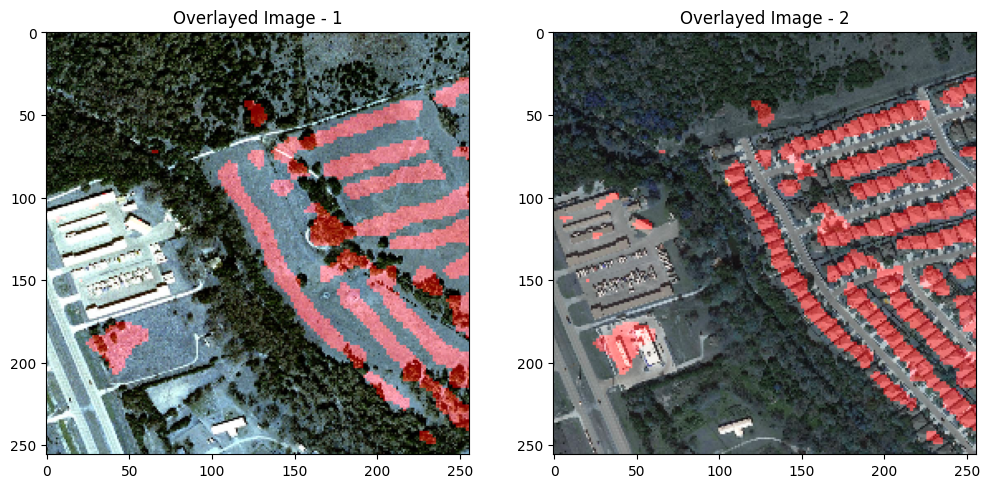

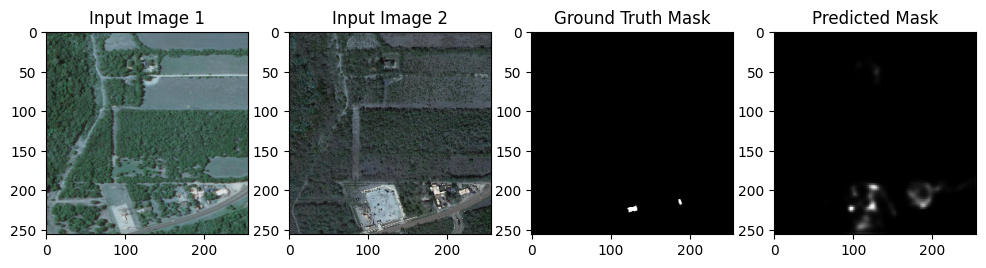

Predictions Min: 8.738280657150849e-22, Max: 0.6121701598167419


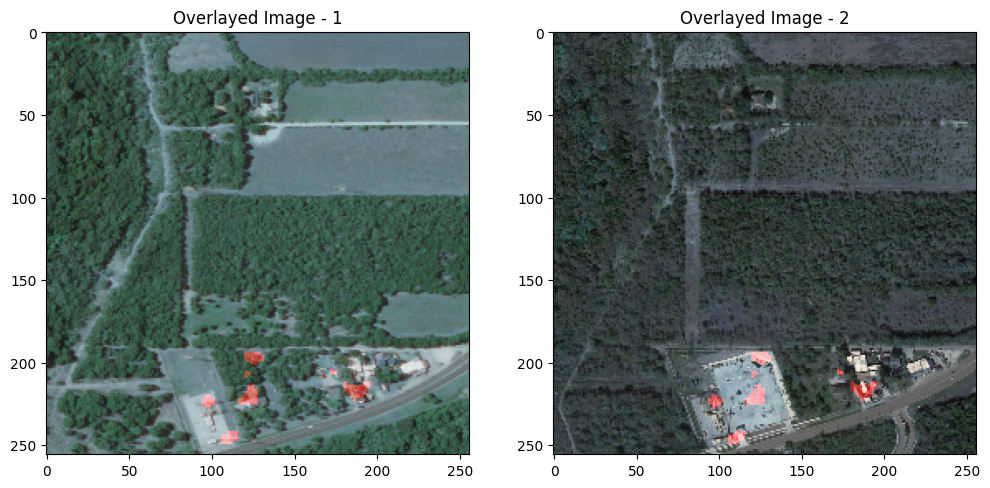

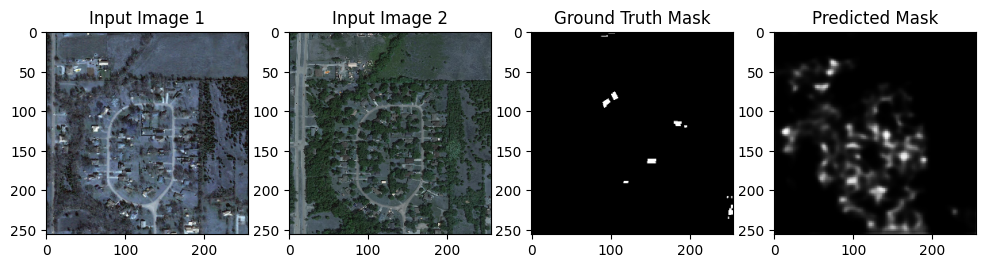

Predictions Min: 2.812626209992158e-30, Max: 0.6926170587539673


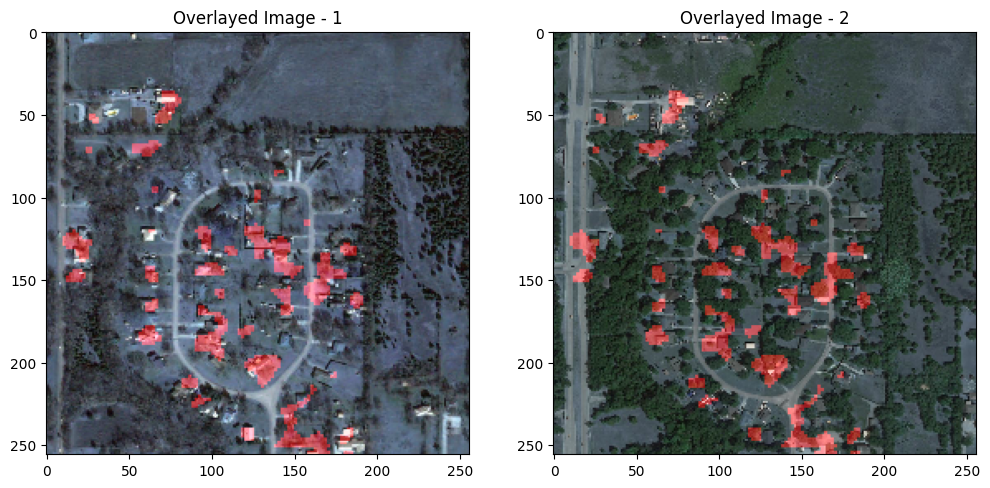

-----------------------------U-Net with RES-Net model----------------------------------------


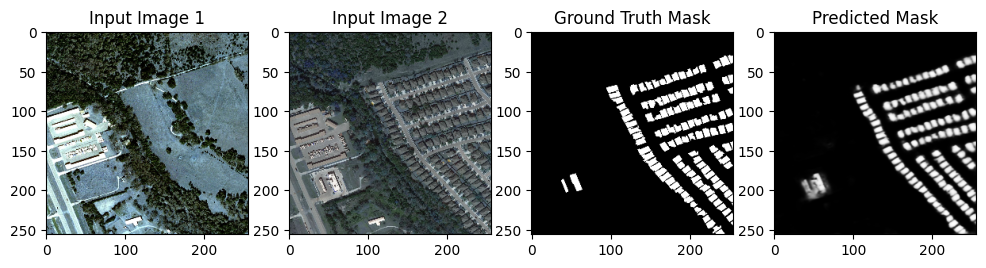

Predictions Min: 1.8469893348083133e-07, Max: 0.9915298223495483


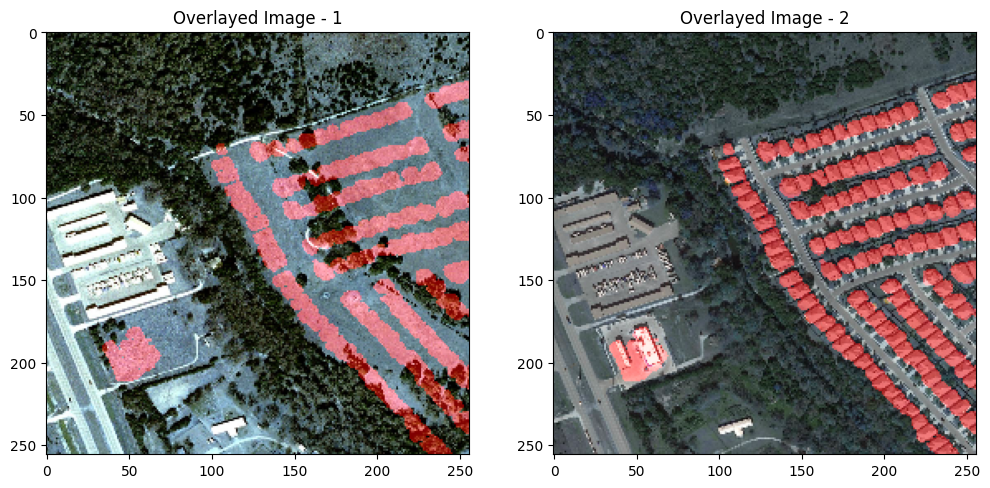

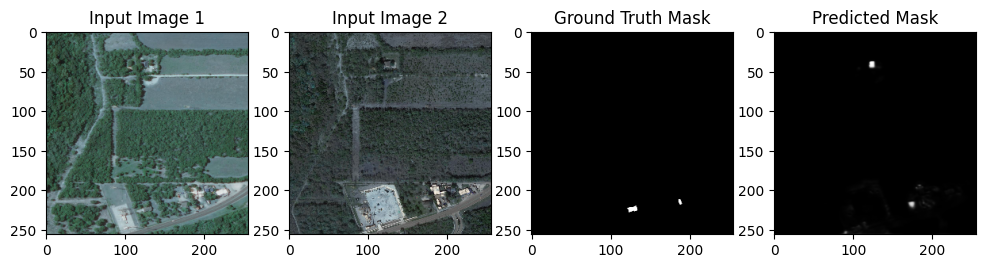

Predictions Min: 4.653786334074539e-08, Max: 0.9444908499717712


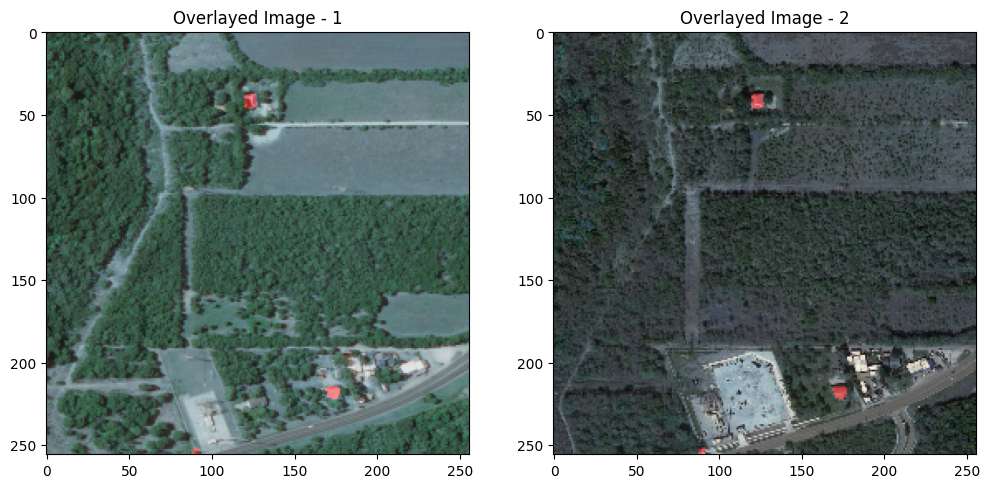

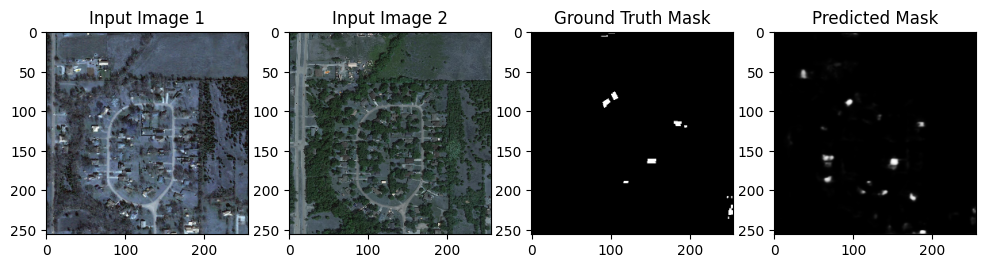

Predictions Min: 2.4776730001008218e-08, Max: 0.9491196274757385


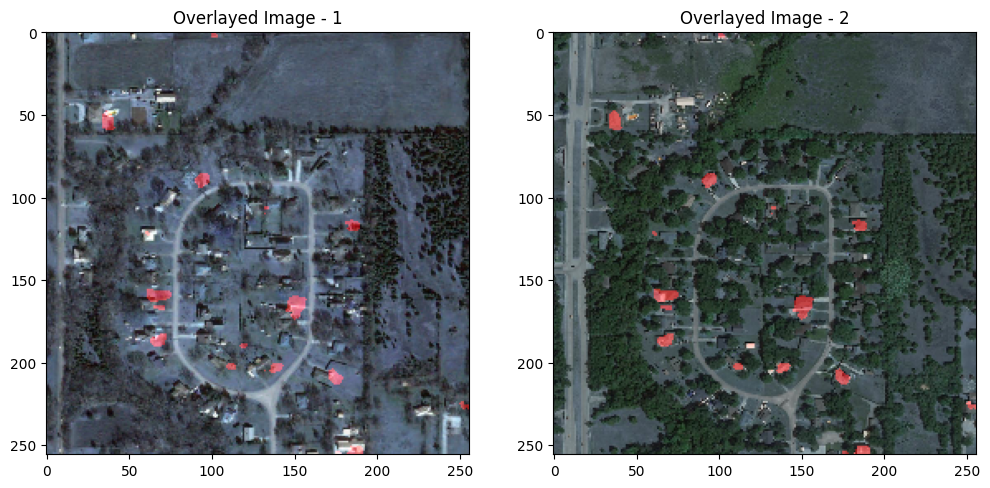

In [16]:
'''def postprocess_predictions(predictions):
        processed_masks = []
        for i, pred in enumerate(predictions):
            threshold = 0.5 * np.max(pred)  # Dynamic threshold
            binary_mask = (pred > threshold).astype(np.uint8)
            # Apply morphological closing to remove noise
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
            cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
            processed_masks.append(cleaned_mask)
        return np.array(processed_masks)
'''

def overlay_mask(image, mask, color=(255, 0, 0), alpha=0.5, max_val = 0.2):
    """
    Overlay a binary mask on an image.
    
    Parameters:
    - image: Original input image (H, W, 3)
    - mask: Binary mask (H, W), values should be 0 or 1
    - color: RGB tuple for the mask color (default: red)
    - alpha: Transparency of the mask overlay (0-1)
    
    Returns:
    - overlayed image
    """
    mask_colored = np.zeros_like(image, dtype=np.uint8)
    mask_colored[mask > max_val] = color

    overlayed = cv2.addWeighted(image, 1, mask_colored, alpha, 0)
    
    return overlayed


predictions = [predictions_unet_with_resnet, predictions_unet]
models = ['U-Net model', 'U-Net with RES-Net model']

for k in range(2):
    print('-----------------------------'+ models[k] +'----------------------------------------')
    #predicted_masks = np.zeros_like(predictions[k])
    '''for i in range(len(predictions)):
        threshold = 0.50 * np.max(predictions[i])  # Compute the dynamic threshold
        predicted_masks[i] = (predictions[i] > threshold).astype(int)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        processed_masks.append(cleaned_mask)'''
    
    #predicted_masks = postprocess_predictions(predictions[k])
    
    # Visualize results
    for i in range(3):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 4, 1)
        plt.imshow(X_test[i, :, :, :3])
        plt.title("Input Image 1")
        plt.subplot(1, 4, 2)
        plt.imshow(X_test[i, :, :, 3:])
        plt.title("Input Image 2")
        plt.subplot(1, 4, 3)
        plt.imshow(y_test[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.subplot(1, 4, 4)
        plt.imshow(predictions[k][i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.show()
        print(f"Predictions Min: {predictions[k][i].min()}, Max: {predictions[k][i].max()}")
        
        
        # Overlay mask on image
        overlayed_image_1 = overlay_mask((X_test[i, :, :, :3] * 255).astype(np.uint8), predictions[k][i].squeeze(), color=(255, 0, 0), alpha=0.5)
        overlayed_image_2 = overlay_mask((X_test[i, :, :, 3:] * 255).astype(np.uint8), predictions[k][i].squeeze(), color=(255, 0, 0), alpha=0.5)

        # Display results
        plt.figure(figsize=(12, 6))
    
        plt.subplot(1, 2, 1)
        plt.imshow(overlayed_image_1)
        plt.title("Overlayed Image - 1")
    
        plt.subplot(1, 2, 2)
        plt.imshow(overlayed_image_2)
        plt.title("Overlayed Image - 2")
    
        plt.show()


In [17]:
model_path = '/kaggle/working/unet_resnet_v1_model.h5'

if os.path.exists(model_path):
    print("Model saved already")
else:
    model_unet.save('unet_v1_model.h5')
    model_unet_with_resnet.save('unet_resnet_v1_model.h5')
    print('saved both models')

saved both models


In [18]:
model_path = '/kaggle/working/unet_v1_model_weights.weights.h5'

if os.path.exists(model_path):
    print("Model saved already")
else:
    model_unet.save_weights('unet_v1_model_weights.weights.h5')
    model_unet_with_resnet.save_weights('unet_resnet_v1_model_weights.weights.h5')
    print('saved both model weights')

saved both model weights
